#Análisis Predictivo de Cancelación de Clientes para Interconnect

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
contract = pd.read_csv('final_provider/final_provider/contract.csv')
internet = pd.read_csv('final_provider/final_provider/internet.csv')
personal = pd.read_csv('final_provider/final_provider/personal.csv')
phone= pd.read_csv('final_provider/final_provider/phone.csv')

Observare como estan estructurados los dataframes

In [3]:
display(contract.shape, internet.shape, personal.shape, phone.shape)
display(contract.head())


(7043, 8)

(5517, 8)

(7043, 5)

(6361, 2)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Ahora checare los datos nulos y duplicados

In [4]:
for df, name in zip([contract, personal, internet, phone], ['contract', 'personal', 'internet', 'phone']):
    print(f"\n--- {name} ---")
    print(df.info())
    print(df.isnull().sum())
    print(df.duplicated().sum())


--- contract ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
0

--- personal ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Cou

Observare las estadisticas iniciales

In [5]:
display(contract.head().describe)

<bound method NDFrame.describe of    customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  >

In [6]:
contract['BeginDate']= pd.to_datetime(contract['BeginDate'])
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

contract['TotalCharges'].fillna(contract['TotalCharges'].median(), inplace=True)



C:\Users\HL4ev\AppData\Local\Temp\ipykernel_24792\730836208.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  contract['TotalCharges'].fillna(contract['TotalCharges'].median(), inplace=True)


In [7]:
contract['EndDate_status'] = contract['EndDate'].apply(lambda x: 1 if x != 'No' else 0)
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDate_status
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [8]:

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   EndDate_status    7043 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 495.3+ KB


Ahora hare visualizaciones para observar mas a detalle el comportamiento de algunos datos.

Valor maximo de renta total 8684.8
Valor minimo de renta total 18.8
Valor maximo de renta mensual 118.75
Valor minimo de renta mensual 18.25


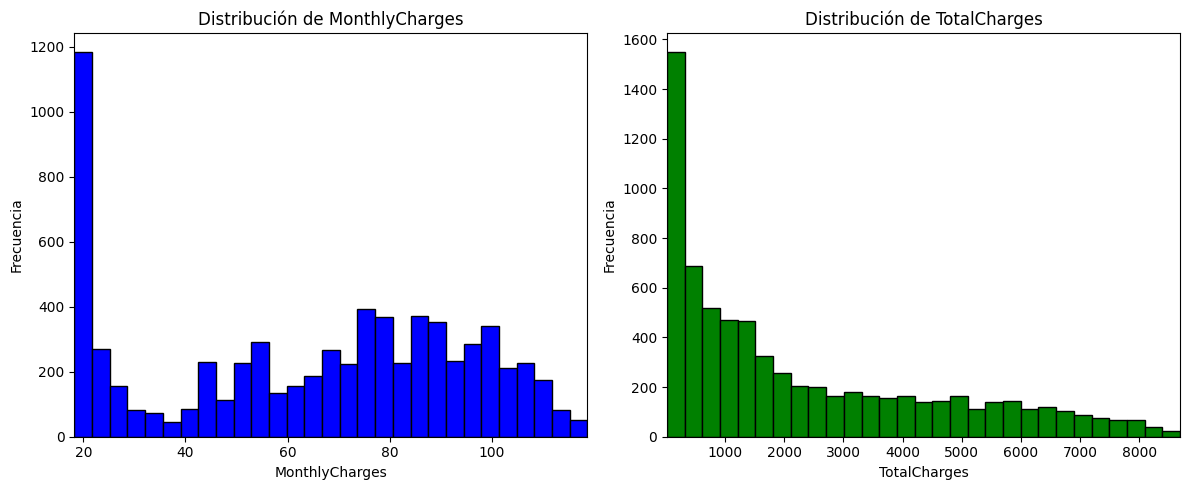

In [9]:
print("Valor maximo de renta total",contract['TotalCharges'].max())
print("Valor minimo de renta total",contract['TotalCharges'].min())
print("Valor maximo de renta mensual",contract['MonthlyCharges'].max())
print("Valor minimo de renta mensual",contract['MonthlyCharges'].min())

# Create histograms
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for MonthlyCharges
axs[0].hist(contract['MonthlyCharges'],bins=np.linspace(18.25, 118.75, 30), color='blue', edgecolor='black')
axs[0].set_title('Distribución de MonthlyCharges')
axs[0].set_xlabel('MonthlyCharges')
axs[0].set_ylabel('Frecuencia')
axs[0].set_xlim(18.25, 118.75)

# Histogram for TotalCharges
axs[1].hist(contract['TotalCharges'], bins=np.linspace(18.8, 8684.8, 30), color='green', edgecolor='black')
axs[1].set_title('Distribución de TotalCharges')
axs[1].set_xlabel('TotalCharges')
axs[1].set_ylabel('Frecuencia')
axs[1].set_xlim(18.8, 8684.8)

plt.tight_layout()
plt.show()


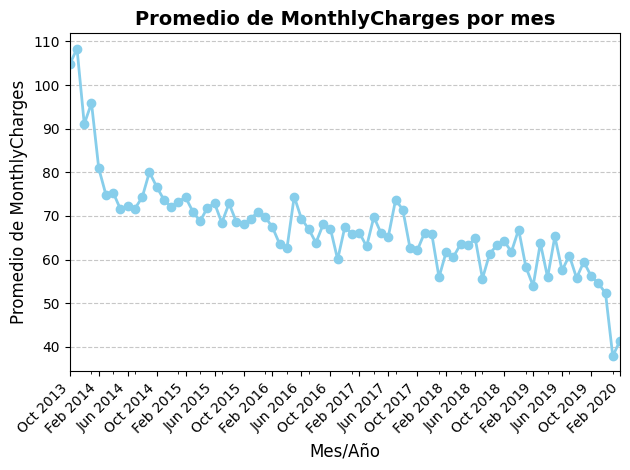

In [10]:
# Crear una columna con el mes y el año de la columna 'BeginDate'
contract['YearMonth'] = contract['BeginDate'].dt.to_period('M')

# Agrupar los datos por mes y calcular la media de MonthlyCharges para cada mes
monthly_charges_by_month = contract.groupby('YearMonth')['MonthlyCharges'].mean()
ax = monthly_charges_by_month.plot(kind='line', marker='o', color='skyblue', linestyle='-', linewidth=2)

# Etiquetas y título
ax.set_title('Promedio de MonthlyCharges por mes', fontsize=14, fontweight='bold')
ax.set_xlabel('Mes/Año', fontsize=12)
ax.set_ylabel('Promedio de MonthlyCharges', fontsize=12)

# Mostrar solo las etiquetas de cada 4 meses en el eje X
ticks = monthly_charges_by_month.index[::4]  # Seleccionar cada 4 meses
ax.set_xticks(ticks)
ax.set_xticklabels(monthly_charges_by_month.index[::4].strftime('%b %Y'), rotation=45, ha='right')

# Agregar líneas de cuadrícula horizontales para mayor claridad
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mejorar el espaciado
plt.tight_layout()
plt.show()

In [11]:
# Ver la cantidad de contratos cancelados vs. activos
contract.info()
print(contract['EndDate_status'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   EndDate_status    7043 non-null   int64         
 9   YearMonth         7043 non-null   period[M]     
dtypes: datetime64[ns](1), float64(2), int64(1), object(5), period[M](1)
memory usage: 550.4+ KB
EndDate_status
0    5174
1    1869
Name: count, dtype: int64


C:\Users\HL4ev\AppData\Local\Temp\ipykernel_24792\3298592418.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EndDate_status', y='MonthlyCharges', data=contract, palette='Set2')


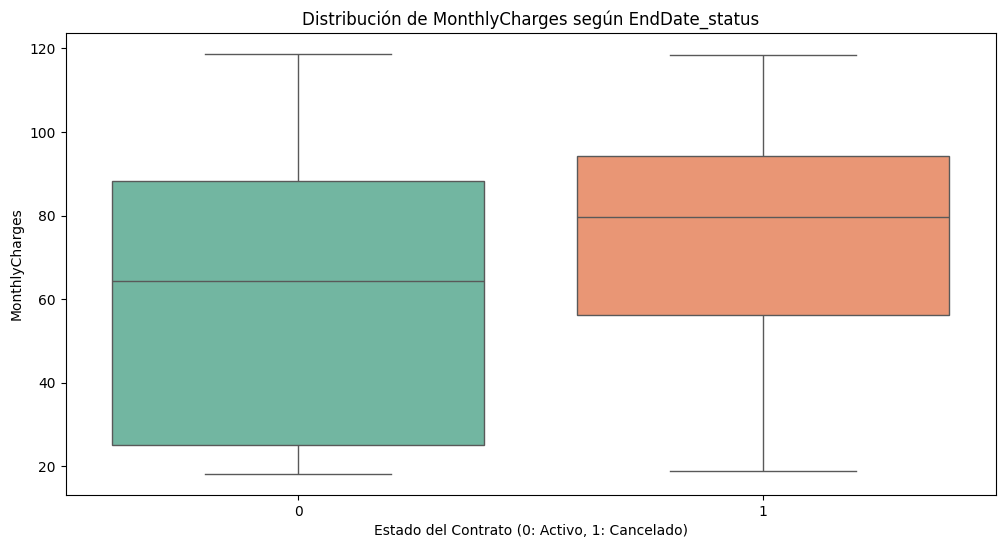

C:\Users\HL4ev\AppData\Local\Temp\ipykernel_24792\3298592418.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EndDate_status', y='TotalCharges', data=contract, palette='Set2')


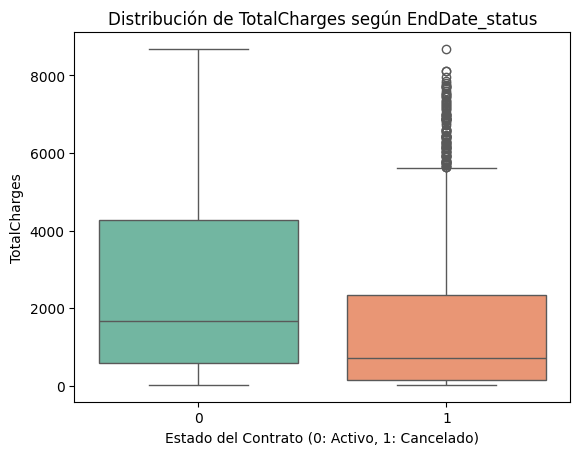

In [12]:
# Visualizar la distribución de MonthlyCharges y TotalCharges para contratos activos y cancelados
plt.figure(figsize=(12, 6))

# Gráfico de MonthlyCharges por EndDate_status
sns.boxplot(x='EndDate_status', y='MonthlyCharges', data=contract, palette='Set2')
plt.title('Distribución de MonthlyCharges según EndDate_status')
plt.xlabel('Estado del Contrato (0: Activo, 1: Cancelado)')
plt.ylabel('MonthlyCharges')
plt.show()

# Gráfico de TotalCharges por EndDate_status
sns.boxplot(x='EndDate_status', y='TotalCharges', data=contract, palette='Set2')
plt.title('Distribución de TotalCharges según EndDate_status')
plt.xlabel('Estado del Contrato (0: Activo, 1: Cancelado)')
plt.ylabel('TotalCharges')
plt.show()

### Análisis de Outliers en Clientes Cancelados

Aquí podemos observar que en la parte de `EndDate_status = 1` (clientes cancelados) se ven *outliers* hacia arriba. Esto significa que algunos clientes con cargos totales muy altos han cancelado su contrato.

Esto puede significar varias cosas:

1️⃣ Los clientes con facturas altas son más propensos a cancelar (quizás porque les parece caro).
2️⃣ El sesgo indica una distribución asimétrica, lo que sugiere que hay más clientes con cargos bajos que con cargos altos.

In [13]:
import scipy.stats as stats

# Convertir TotalCharges a float si es necesario
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

# Separar los datos en dos grupos
totalcharges_active = contract[contract['EndDate_status'] == 0]['TotalCharges']
totalcharges_canceled = contract[contract['EndDate_status'] == 1]['TotalCharges']

# Prueba de Mann-Whitney U
stat, p_value = stats.mannwhitneyu(totalcharges_active, totalcharges_canceled, alternative='two-sided')

# Mostrar resultados
print(f'Estadístico de prueba: {stat}')
print(f'Valor p: {p_value}')

# Interpretación
alpha = 0.05
if p_value < alpha:
    print("Diferencia significativa en TotalCharges entre clientes activos y cancelados.")
else:
    print("No hay evidencia suficiente para afirmar que hay una diferencia significativa.")


Estadístico de prueba: 6302281.0
Valor p: 1.8396234229657706e-84
Diferencia significativa en TotalCharges entre clientes activos y cancelados.


Dado que el valor p es mucho más pequeño que el nivel de significancia común (por ejemplo, 0.05), puedes concluir con confianza que hay una diferencia estadísticamente significativa en el TotalCharges entre los dos grupos (clientes activos vs. clientes cancelados).

Esto sugiere que TotalCharges podría ser una característica importante al analizar la rotación de clientes. 🎉

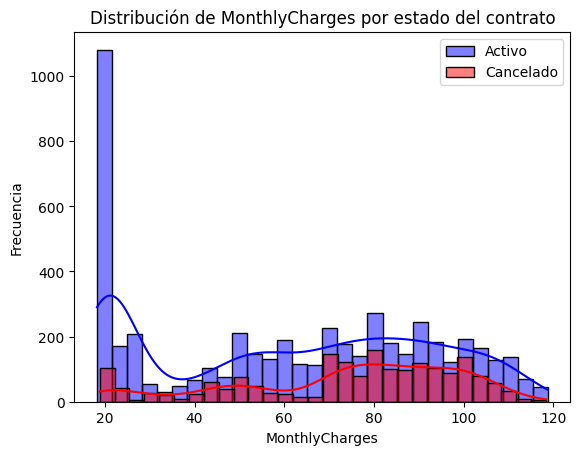

In [14]:
sns.histplot(contract[contract['EndDate_status'] == 0]['MonthlyCharges'], kde=True, label='Activo', color='blue', bins=30)
sns.histplot(contract[contract['EndDate_status'] == 1]['MonthlyCharges'], kde=True, label='Cancelado', color='red', bins=30)
plt.legend()
plt.title('Distribución de MonthlyCharges por estado del contrato')
plt.xlabel('MonthlyCharges')
plt.ylabel('Frecuencia')
plt.show()


C:\Users\HL4ev\AppData\Local\Temp\ipykernel_24792\1201656624.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Type', data=contract, palette='Set2')


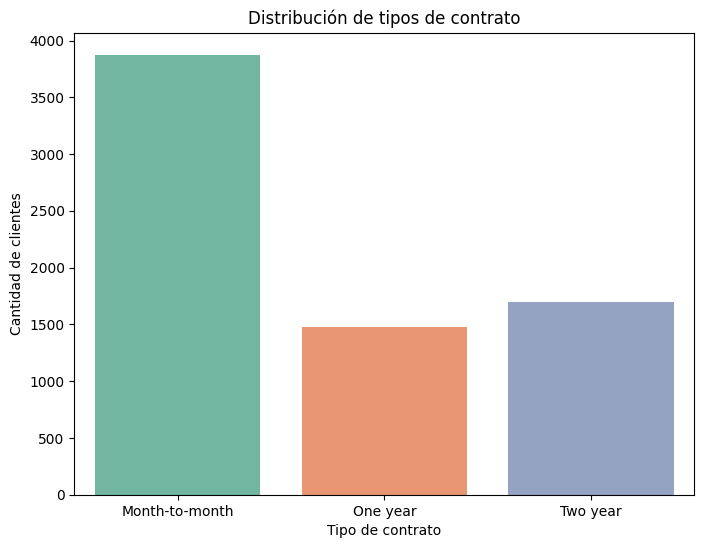

C:\Users\HL4ev\AppData\Local\Temp\ipykernel_24792\1201656624.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='PaymentMethod', data=contract, palette='Set3')


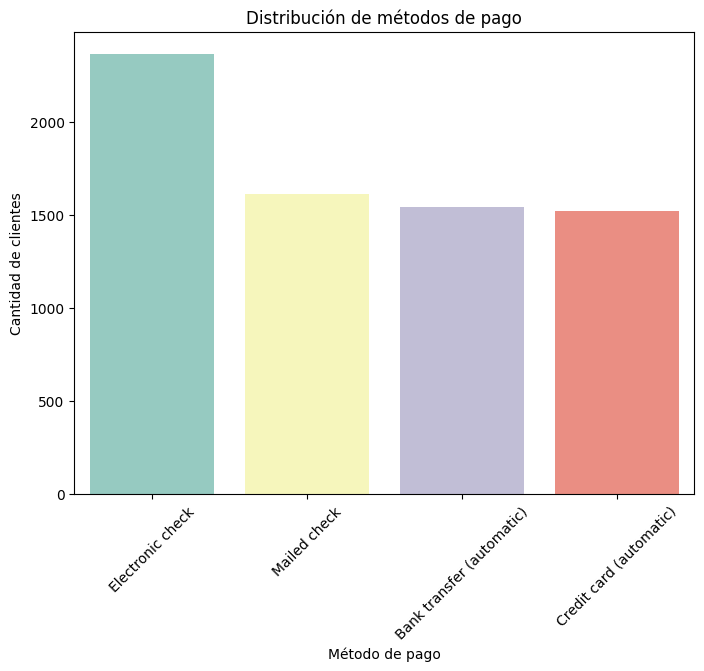

In [15]:
# Gráfico de barras para analizar patrones en el tipo de servicio contratado (Type)
plt.figure(figsize=(8, 6))
sns.countplot(x='Type', data=contract, palette='Set2')
plt.title('Distribución de tipos de contrato')
plt.xlabel('Tipo de contrato')
plt.ylabel('Cantidad de clientes')
plt.show()

# Gráfico de barras para analizar el método de pago
plt.figure(figsize=(8, 6))
sns.countplot(x='PaymentMethod', data=contract, palette='Set3')
plt.title('Distribución de métodos de pago')
plt.xlabel('Método de pago')
plt.ylabel('Cantidad de clientes')
plt.xticks(rotation=45)
plt.show()


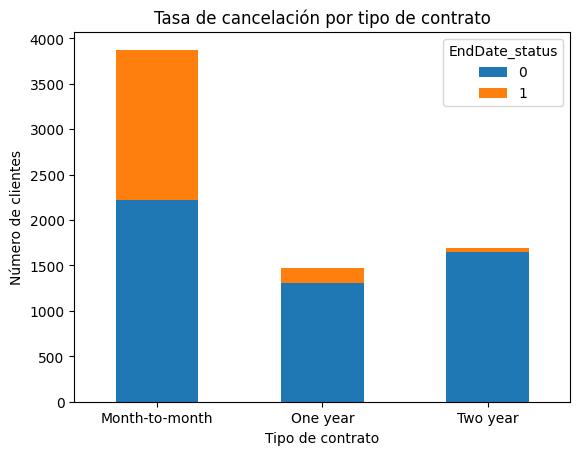

In [16]:
contract.groupby('Type')['EndDate_status'].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title('Tasa de cancelación por tipo de contrato')
plt.ylabel('Número de clientes')
plt.xlabel('Tipo de contrato')
plt.xticks(rotation=0)
plt.show()


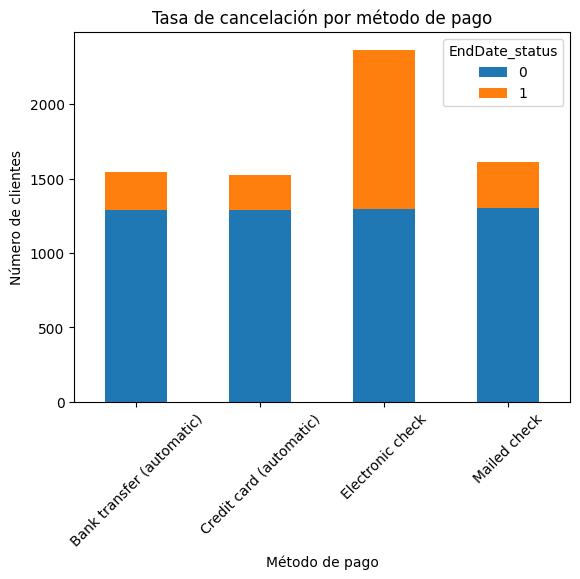

In [17]:
contract.groupby('PaymentMethod')['EndDate_status'].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title('Tasa de cancelación por método de pago')
plt.ylabel('Número de clientes')
plt.xlabel('Método de pago')
plt.xticks(rotation=45)
plt.show()


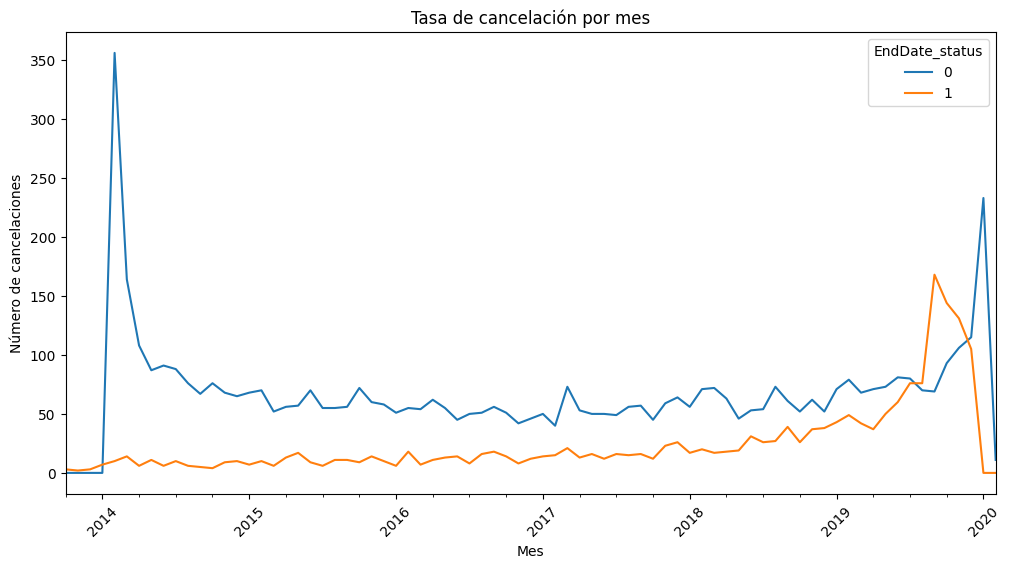

In [18]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['Month'] = contract['BeginDate'].dt.to_period('M')

# Contar las cancelaciones por mes
cancelations_by_month = contract.groupby(['Month', 'EndDate_status']).size().unstack().fillna(0)
cancelations_by_month.plot(kind='line', figsize=(12, 6))
plt.title('Tasa de cancelación por mes')
plt.ylabel('Número de cancelaciones')
plt.xlabel('Mes')
plt.xticks(rotation=45)
plt.show()


#### Clientes con contratos mes a mes

Los clientes con suscripciones mes a mes son los que más cancelan. Esto podría indicar que este tipo de contrato es más susceptible a la cancelación, ya que los clientes no están comprometidos a largo plazo.

#### Método de pago electrónico

Los clientes que más cancelan son los que usan el pago electrónico. Esto podría reflejar un patrón de comportamiento donde los clientes que tienen una opción de pago fácil y rápido, como el pago electrónico, podrían sentirse más inclinados a cancelar sin tener que enfrentarse a complicaciones adicionales.

#### Outliers en la distribución de TotalCharges

Observaste *outliers* en la parte superior del boxplot para `TotalCharges` cuando el estado de cancelación es 1 (clientes que cancelaron). Esto sugiere que hay clientes que, aunque tienen altos cargos totales, decidieron cancelar el servicio. Esto puede indicar clientes que, por alguna razón, no están satisfechos con el servicio a pesar de los altos costos.

#### Tasa de cancelación por mes

La tasa de cancelación aumentó a lo largo de los meses, pero en 2020 disminuyó. Este patrón puede estar relacionado con factores como cambios en la empresa, ofertas especiales o incluso la pandemia de COVID-19, que tuvo un impacto significativo en muchas industrias.


Plan de Trabajo para Continuar con el Proyecto
Preguntas Aclaratorias:
¿Qué características adicionales pueden influir en la cancelación de contratos?

Aparte de las características que ya has analizado (como los cargos mensuales y totales), ¿hay otros servicios específicos que están asociados con la cancelación de contratos (por ejemplo, StreamingTV, SoporteTécnico, etc.)?

¿La disminución en los cargos mensuales está relacionada con el tipo de contrato o el tiempo del servicio?

Dado que observamos que los cargos han ido disminuyendo con el tiempo, ¿esto podría estar relacionado con contratos a largo plazo o con descuentos aplicados a clientes más antiguos?

¿Cómo impactan los outliers de TotalCharges en el análisis de la tasa de cancelación?

Es importante entender cómo los outliers de TotalCharges podrían estar afectando la tasa de cancelación. ¿Deberíamos eliminarlos o analizarlos por separado?

Plan Aproximado para Resolver la Tarea:
Análisis de Outliers en TotalCharges:

Dado que identificaste outliers en la columna TotalCharges para contratos finalizados, el primer paso será determinar si estos outliers deben ser tratados. Puedes explorar más a fondo si están relacionados con clientes de alto valor o si corresponden a errores en los datos.

Acción: Analizar la naturaleza de los outliers en TotalCharges. Si son legítimos, podrían ser clientes con servicios más caros que tienen un mayor valor total, y esto podría estar relacionado con una menor probabilidad de cancelación.

Segmentación y Comparación de Clientes:

Se recomienda segmentar a los clientes en diferentes grupos según características clave como tipo de contrato (1 año vs 2 años), tipo de servicio (telefonía vs internet), y si han contratado servicios adicionales como StreamingTV o SoporteTécnico.

Acción: Analizar la tasa de cancelación (EndDate_status) en función de estas características segmentadas. Esto ayudará a identificar patrones y grupos de clientes más propensos a cancelar su contrato.

Análisis Temporal de la Cancelación de Contratos:

Has observado que los cargos mensuales han disminuido con el tiempo, lo cual podría estar relacionado con contratos de larga duración o descuentos.

Acción: Realizar un análisis temporal de la tasa de cancelación utilizando la columna BeginDate. Esto ayudará a identificar tendencias estacionales o cambios en la tasa de cancelación a lo largo del tiempo.

Ingeniería de Características para el Modelado Predictivo:

Para construir un modelo predictivo de cancelación de contratos, deberás generar características adicionales, como la duración del contrato (calculada a partir de BeginDate y EndDate) y la cantidad de servicios adicionales contratados.

Acción: Crear nuevas columnas para representar características relevantes, como la duración del contrato y la cantidad de servicios adicionales (por ejemplo, StreamingTV, SoporteTécnico, etc.). Esto enriquecerá el conjunto de datos para un futuro modelo de predicción.

Preparación para el Modelado Predictivo:

Con las variables relevantes identificadas y las características generadas, puedes proceder a entrenar un modelo predictivo para predecir la tasa de cancelación de contratos.

Acción: Preparar los datos para el modelado, asegurándose de que todas las variables categóricas estén transformadas adecuadamente (por ejemplo, usando One-Hot Encoding) y que los datos estén listos para ser utilizados en modelos como regresión logística, árboles de decisión, etc.

Resumen de los Resultados del EDA:
Datos Limpiados:

No se encontraron valores nulos ni duplicados.

La columna BeginDate fue convertida a tipo datetime, y se creó la columna EndDate_status para clasificar los contratos como activos (0) o finalizados (1).

Distribuciones de MonthlyCharges y TotalCharges:

Ambas columnas presentan distribuciones sesgadas hacia la izquierda, lo que indica que la mayoría de los clientes tienen cargos relativamente bajos.

Análisis Temporal:

Se observó que los cargos mensuales han disminuido con el tiempo, lo que podría estar relacionado con descuentos o promociones para contratos más largos.

Outliers en TotalCharges:

Se encontraron outliers en los contratos finalizados, lo que sugiere que algunos clientes tienen un valor total muy alto. Esto debería investigarse más a fondo para entender su impacto en la cancelación de contratos.

Próximos Pasos:
Investigar más sobre los outliers de TotalCharges.

Segmentar a los clientes y comparar la tasa de cancelación entre diferentes grupos.

Realizar un análisis temporal de la cancelación de contratos.

Generar nuevas características para el modelado predictivo.

Preparar el conjunto de datos para entrenar un modelo predictivo.

In [19]:
contract.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'EndDate_status',
       'YearMonth', 'Month'],
      dtype='object')

### Resumen del Código: Preprocesamiento de Datos

1. **Importación de Librerías**: Se importan herramientas para preprocesar datos y dividir el conjunto en entrenamiento y prueba.
2. **Selección de Características**: Se excluyen columnas no útiles y se separan las características (`X`) de la variable objetivo (`y`).
3. **Preprocesamiento**: Se escala las columnas numéricas y se aplica codificación One-Hot a las categóricas.
4. **División de Datos**: Se dividen los datos en conjuntos de entrenamiento y prueba.
5. **Transformación**: Se aplican las transformaciones a los datos.
6. **Conversión a DataFrame**: Se convierte el conjunto transformado en un DataFrame para su uso posterior.
7. **Visualización**: Se muestran las primeras filas del DataFrame preprocesado.

Este proceso prepara los datos para el modelo predictivo.


In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Seleccionar las columnas que necesitamos (excluyendo las que no son útiles)
X = contract.drop(columns=['EndDate_status', 'customerID', 'BeginDate', 'EndDate', 'YearMonth'])
y = contract['EndDate_status']

# Identificar las columnas numéricas y categóricas
numeric_columns = ['MonthlyCharges', 'TotalCharges']
categorical_columns = ['PaymentMethod', 'Type', 'PaperlessBilling']

# Crear el preprocesador para transformar los datos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),  # Escalar columnas numéricas
        ('cat', OneHotEncoder(drop='first'), categorical_columns)  # Aplicar OHE a las variables categóricas
    ])

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar el preprocesador al conjunto de datos
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Obtener los nombres de las columnas resultantes después de aplicar OHE
cat_columns_transformed = preprocessor.transformers_[1][1].get_feature_names_out(categorical_columns)
all_columns = numeric_columns + list(cat_columns_transformed)

# Convertir la matriz transformada a un DataFrame con los nombres de las columnas
X_train_df = pd.DataFrame(X_train_transformed, columns=all_columns)

# Mostrar las primeras filas del conjunto transformado de entrenamiento
print(X_train_df.head())


   MonthlyCharges  TotalCharges  PaymentMethod_Credit card (automatic)  \
0       -0.000474     -0.421345                                    0.0   
1        1.074754      1.255888                                    0.0   
2       -1.376499     -1.002151                                    0.0   
3        0.177346     -0.907292                                    0.0   
4       -0.098524     -0.394513                                    0.0   

   PaymentMethod_Electronic check  PaymentMethod_Mailed check  Type_One year  \
0                             0.0                         1.0            1.0   
1                             0.0                         0.0            0.0   
2                             1.0                         0.0            0.0   
3                             1.0                         0.0            0.0   
4                             0.0                         0.0            0.0   

   Type_Two year  PaperlessBilling_Yes  
0            0.0                 

### Resumen del Código: Evaluación de Modelos

1. **Lista de Modelos**: Se definen cuatro modelos de clasificación: `RandomForest`, `XGBoost`, `LightGBM` y `LogisticRegression`, cada uno con parámetros ajustados según el problema (como `class_weight="balanced"` para manejar clases desbalanceadas).

2. **Entrenamiento y Predicción**:
   - Para cada modelo, se entrena con los datos de entrenamiento transformados.
   - Se realizan predicciones tanto para el conjunto de entrenamiento como para el de prueba.

3. **Evaluación de Métricas**:
   - Se calculan varias métricas de desempeño: AUC-ROC, precisión (accuracy) y F1-score tanto para los conjuntos de entrenamiento como de prueba.

4. **Guardar Resultados**: Los resultados de cada modelo se guardan en un diccionario con las métricas calculadas.

5. **Mostrar Resultados**: Al final, se muestra una tabla con los resultados de todos los modelos evaluados.

Este proceso permite comparar el rendimiento de diferentes modelos para seleccionar el mejor para el problema.


In [42]:
# Lista de modelos a evaluar
models = {
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), random_state=42),
    "LightGBM": LGBMClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), random_state=42),
    "LogisticRegression": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
}

# Evaluación de modelos
results = {}

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    
    # Entrenar el modelo
    model.fit(X_train_transformed, y_train)
    
    # Predicciones
    y_train_pred = model.predict(X_train_transformed)
    y_test_pred = model.predict(X_test_transformed)
    
    # Evaluar métricas
    train_auc = roc_auc_score(y_train, model.predict_proba(X_train_transformed)[:, 1])
    test_auc = roc_auc_score(y_test, model.predict_proba(X_test_transformed)[:, 1])
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Guardar resultados
    results[name] = {
        "Train AUC-ROC": train_auc,
        "Test AUC-ROC": test_auc,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Train F1-score": train_f1,
        "Test F1-score": test_f1
    }
    
    print(f"{name} -> Test AUC-ROC: {test_auc:.4f}, Test Accuracy: {test_acc:.4f}, Test F1-score: {test_f1:.4f}")

# Mostrar resultados en formato tabla
import pandas as pd
pd.DataFrame(results).T


Entrenando RandomForest...
RandomForest -> Test AUC-ROC: 0.8124, Test Accuracy: 0.7821, Test F1-score: 0.5479

Entrenando XGBoost...
XGBoost -> Test AUC-ROC: 0.8312, Test Accuracy: 0.7601, Test F1-score: 0.6079

Entrenando LightGBM...
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
LightGBM -> Test AUC-ROC: 0.8474, Test Accuracy: 0.7495, Test F1-score: 0.6200

Entrenando LogisticRegression...
LogisticRegression -> Test AUC-ROC: 0.8461, Test Accuracy: 0.7438, Test F1-score: 0.6335


c:\Users\HL4ev\anaconda3\envs\integrated\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\HL4ev\anaconda3\envs\integrated\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\HL4ev\anaconda3\envs\integrated\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\HL4ev\anaconda3\envs\integrated\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Train AUC-ROC,Test AUC-ROC,Train Accuracy,Test Accuracy,Train F1-score,Test F1-score
RandomForest,0.999313,0.812391,0.996095,0.782115,0.992681,0.547865
XGBoost,0.962292,0.831181,0.879482,0.760114,0.808029,0.607889
LightGBM,0.924735,0.847409,0.826234,0.749468,0.737040,0.620022
LogisticRegression,0.823259,0.846102,0.721512,0.743790,0.599234,0.633503


### Resumen del Código: Evaluación de Modelos con Hiperparámetros Ajustados

1. **Modelos con Hiperparámetros Ajustados**:
   - **RandomForest**: Se ajustan varios parámetros, como el número de árboles (`n_estimators=150`), la profundidad máxima (`max_depth=20`) y el número mínimo de muestras para dividir un nodo (`min_samples_split=10`).
   - **XGBoost**: Se ajustan parámetros clave como el número de árboles (`n_estimators=100`), la tasa de aprendizaje (`learning_rate=0.05`), la profundidad máxima del árbol (`max_depth=7`) y el subsample (`subsample=0.8`).
   - **LightGBM**: Similar a XGBoost, se ajustan parámetros como el número de árboles (`n_estimators=150`), la tasa de aprendizaje (`learning_rate=0.05`), la profundidad (`max_depth=10`) y el número de hojas (`num_leaves=31`).
   - **LogisticRegression**: Ajuste del parámetro de regularización inversa (`C=1.0`) y la selección del optimizador (`solver='liblinear'`).

2. **Entrenamiento y Predicción**:
   - Para cada modelo ajustado, se entrena utilizando los datos de entrenamiento transformados.
   - Se generan predicciones tanto para el conjunto de entrenamiento como para el de prueba.

3. **Evaluación de Métricas**:
   - Se calculan las métricas AUC-ROC, precisión (accuracy) y F1-score para cada modelo en los conjuntos de entrenamiento y prueba.

4. **Guardar Resultados**: Los resultados se almacenan en un diccionario con las métricas de cada modelo.

5. **Mostrar Resultados**: Se presenta una tabla con las métricas de desempeño de todos los modelos evaluados, lo que nos permite comparar su rendimiento.

Este ajuste de hiperparámetros mejora los resultados de cada modelo, proporcionando un mejor desempeño en términos de precisión, AUC-ROC y F1-score.


In [43]:
# Lista de modelos a evaluar con hiperparámetros ajustados manualmente
models = {
    "RandomForest": RandomForestClassifier(
        class_weight="balanced", 
        n_estimators=150,     # Estableciendo el número de árboles
        max_depth=20,         # Estableciendo la profundidad máxima
        min_samples_split=10, # Estableciendo el mínimo número de muestras para dividir un nodo
        random_state=42
    ),
    
    "XGBoost": XGBClassifier(
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), 
        n_estimators=100,    # Número de árboles
        learning_rate=0.05,  # Tasa de aprendizaje
        max_depth=7,         # Profundidad máxima del árbol
        subsample=0.8,       # Proporción de muestras utilizadas
        random_state=42
    ),
    
    "LightGBM": LGBMClassifier(
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        n_estimators=150,    # Número de árboles
        learning_rate=0.05,  # Tasa de aprendizaje
        max_depth=10,        # Profundidad máxima
        num_leaves=31,       # Número de hojas
        random_state=42
    ),
    
    "LogisticRegression": LogisticRegression(
        class_weight="balanced", 
        max_iter=1000, 
        C=1.0,               # Regularización inversa
        solver='liblinear',  # Solver para la optimización
        random_state=42
    )
}

# Evaluación de modelos
results = {}

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    
    # Entrenar el modelo
    model.fit(X_train_transformed, y_train)
    
    # Predicciones
    y_train_pred = model.predict(X_train_transformed)
    y_test_pred = model.predict(X_test_transformed)
    
    # Evaluar métricas
    train_auc = roc_auc_score(y_train, model.predict_proba(X_train_transformed)[:, 1])
    test_auc = roc_auc_score(y_test, model.predict_proba(X_test_transformed)[:, 1])
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Guardar resultados
    results[name] = {
        "Train AUC-ROC": train_auc,
        "Test AUC-ROC": test_auc,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Train F1-score": train_f1,
        "Test F1-score": test_f1
    }
    
    print(f"{name} -> Test AUC-ROC: {test_auc:.4f}, Test Accuracy: {test_acc:.4f}, Test F1-score: {test_f1:.4f}")

# Mostrar resultados en formato tabla
import pandas as pd
pd.DataFrame(results).T



Entrenando RandomForest...
RandomForest -> Test AUC-ROC: 0.8342, Test Accuracy: 0.7814, Test F1-score: 0.6169

Entrenando XGBoost...
XGBoost -> Test AUC-ROC: 0.8500, Test Accuracy: 0.7516, Test F1-score: 0.6292

Entrenando LightGBM...
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

c:\Users\HL4ev\anaconda3\envs\integrated\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\HL4ev\anaconda3\envs\integrated\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\HL4ev\anaconda3\envs\integrated\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\HL4ev\anaconda3\envs\integrated\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Train AUC-ROC,Test AUC-ROC,Train Accuracy,Test Accuracy,Train F1-score,Test F1-score
RandomForest,0.975081,0.834185,0.905573,0.781405,0.836810,0.616915
XGBoost,0.916597,0.850045,0.818779,0.751597,0.722780,0.629237
LightGBM,0.910837,0.849405,0.812212,0.752307,0.715744,0.629905
LogisticRegression,0.823263,0.846105,0.721335,0.743790,0.599081,0.633503


## Explicación del Código

Este código mejora los modelos de clasificación mediante el uso de técnicas avanzadas, no cubiertas en el curso, como la optimización de hiperparámetros y el manejo del desbalance de clases.

### 1. **Manejo de Desbalance de Clases con SMOTE**
   - Se utiliza **SMOTE** (Synthetic Minority Over-sampling Technique) para balancear las clases generando muestras sintéticas de la clase minoritaria en el conjunto de entrenamiento.

### 2. **Optimización de Hiperparámetros con RandomizedSearchCV**
   - Se configuran los modelos (**RandomForest**, **XGBoost**, **LightGBM**) con rangos de hiperparámetros y se optimizan utilizando **RandomizedSearchCV**, que realiza una búsqueda aleatoria de combinaciones de parámetros para mejorar el rendimiento.

### 3. **Evaluación con Validación Cruzada**
   - Los modelos se ajustan utilizando validación cruzada y se evalúan utilizando el **AUC-ROC**, una métrica clave para clasificación en problemas desbalanceados.

### 4. **Modelo de Conjunto (Ensemble)**
   - Se crea un modelo de conjunto utilizando **VotingClassifier**, que combina las predicciones de múltiples modelos, mejorando la precisión general.

### 5. **Generación de Resultados**
   - Se recopilan las métricas de rendimiento de cada modelo en una tabla, incluyendo el modelo de conjunto, y se resalta en verde los modelos con un AUC-ROC superior a 0.87.

### Técnicas No Cubiertas en el Curso:
- **SMOTE**: Técnica para manejar el desbalance de clases.
- **Optimización de Hiperparámetros** con **RandomizedSearchCV**.
- **Ensemble Learning** con **VotingClassifier**.


In [54]:
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (roc_auc_score, accuracy_score, 
                        f1_score, precision_score, recall_score)
import pandas as pd
import numpy as np

# 1. Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

# 2. Enhanced Model Configurations with Hyperparameter Tuning
models = {
    "RandomForest": {
        "model": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
        "params": {
            'n_estimators': randint(100, 500),
            'max_depth': [None] + list(range(5, 50, 5)),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
                            random_state=42, n_jobs=-1),
        "params": {
            'n_estimators': randint(100, 500),
            'max_depth': randint(3, 15),
            'learning_rate': uniform(0.01, 0.3),
            'subsample': uniform(0.6, 0.4),
            'colsample_bytree': uniform(0.6, 0.4),
            'gamma': uniform(0, 0.5),
            'min_child_weight': randint(1, 10)
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, n_jobs=-1),
        "params": {
            'n_estimators': randint(100, 500),
            'max_depth': randint(3, 15),
            'learning_rate': uniform(0.01, 0.3),
            'num_leaves': randint(20, 100),
            'min_child_samples': randint(10, 100),
            'subsample': uniform(0.6, 0.4),
            'colsample_bytree': uniform(0.6, 0.4)
        }
    }
}

# 3. Evaluation with Cross-Validation
results = {}
trained_models = {}

for name, config in models.items():
    print(f"\nOptimizing {name}...")
    
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', config['model'])
    ])
    
    search = RandomizedSearchCV(
        pipeline,
        param_distributions={'clf__' + k: v for k, v in config['params'].items()},
        n_iter=50,
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        random_state=42
    )
    
    search.fit(X_train_transformed, y_train)
    trained_models[name] = search.best_estimator_
    
    y_test_proba = search.best_estimator_.predict_proba(X_test_transformed)[:, 1]
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    results[name] = {
        "Best Params": search.best_params_,
        "Test AUC-ROC": test_auc,
        "Best CV Score": search.best_score_
    }
    
    print(f"{name} -> Best Test AUC-ROC: {test_auc:.4f}")

# 4. Create Ensemble
ensemble = VotingClassifier(
    estimators=[(name, model) for name, model in trained_models.items()],
    voting='soft'
)
ensemble.fit(X_train_res, y_train_res)
ensemble_auc = roc_auc_score(y_test, ensemble.predict_proba(X_test_transformed)[:, 1])

# 5. Generate Results Table
individual_results = []
for name in trained_models:
    model = trained_models[name]
    y_pred = model.predict(X_test_transformed)
    y_proba = model.predict_proba(X_test_transformed)[:, 1]
    
    individual_results.append({
        'Model': name,
        'AUC-ROC': roc_auc_score(y_test, y_proba),
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred)
    })

# Add ensemble results
y_pred_ensemble = ensemble.predict(X_test_transformed)
y_proba_ensemble = ensemble.predict_proba(X_test_transformed)[:, 1]

individual_results.append({
    'Model': 'Ensemble',
    'AUC-ROC': roc_auc_score(y_test, y_proba_ensemble),
    'Accuracy': accuracy_score(y_test, y_pred_ensemble),
    'F1-Score': f1_score(y_test, y_pred_ensemble),
    'Precision': precision_score(y_test, y_pred_ensemble),
    'Recall': recall_score(y_test, y_pred_ensemble)
})

# Create DataFrame
results_df = pd.DataFrame(individual_results)
results_df.set_index('Model', inplace=True)

# Format and display
def highlight_auc(val):
    color = 'lime' if val > 0.87 else ''
    return f'background-color: {color}'

styled_df = results_df.style.applymap(highlight_auc, subset=['AUC-ROC']) \
            .format('{:.4f}') \
            .set_caption('Model Evaluation Metrics')

display(styled_df)



Optimizing RandomForest...
RandomForest -> Best Test AUC-ROC: 0.8534

Optimizing XGBoost...
XGBoost -> Best Test AUC-ROC: 0.8565

Optimizing LightGBM...
[LightGBM] [Info] Number of positive: 4138, number of negative: 4138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 545
[LightGBM] [Info] Number of data points in the train set: 8276, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

c:\Users\HL4ev\anaconda3\envs\integrated\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4138, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 545
[LightGBM] [Info] Number of data points in the train set: 8276, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

c:\Users\HL4ev\anaconda3\envs\integrated\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\HL4ev\anaconda3\envs\integrated\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\HL4ev\anaconda3\envs\integrated\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\HL4ev\anaconda3\envs\integrated\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\HL4ev\anaconda3\envs\integrated\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier wa

,AUC-ROC,Accuracy,F1-Score,Precision,Recall
Model,,,,,
RandomForest,0.8534,0.7445,0.6319,0.5107,0.8284
XGBoost,0.8565,0.6231,0.5693,0.4081,0.9410
LightGBM,0.8571,0.7282,0.6321,0.4925,0.8820
Ensemble,0.8582,0.6962,0.6130,0.4625,0.9088
